In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
from os import path
import yaml

Read in the data from the base / "from-scratch" knee models, take the average of metrics across folds, and get it down to a dataframe that just has dice coefficients for the best performing version of each model architecture.

In [42]:
base = pd.read_csv(path.join("..", "from_arc", "knee_base_cv.csv"))
base = base[[
    "label", "version", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
base = base.groupby(["label", "version"]).mean().drop(columns=["fold"])
base = base[
    base.groupby(["label"])["metrics_val_dsc_0_epoch_final"].transform(max) 
    == base["metrics_val_dsc_0_epoch_final"]
].dropna()
base = base.reset_index()

base["label"] = base["label"].apply(lambda x: x[0:-16])

best_base_models = [(l,v) for l,v in zip(base["label"], base["version"])]

base = pd.read_csv(path.join("..", "from_arc", "knee_base_cv.csv"))
base = base[[
    "label", "version", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
base["label"] = base["label"].apply(lambda x: x[0:-16])

df = pd.DataFrame()

for l, v in best_base_models:
    df = df.append(base[(base["label"]==l) & (base["version"]==v)])

base = df
    
base

labels_renaming = {
    "unet": "UNet",
    "unetpp": "UNet++",
    "unetr": "UNETR",
    "segresnetvae": "SegResNetVAE",
    "segan": "SeGAN"
}
base = base.replace({"label": labels_renaming})

base = base.rename(
    columns = {
        "metrics_val_dsc_0_epoch_final": "cort DSC",
        "metrics_val_dsc_1_epoch_final": "trab DSC",
        "metrics_val_dsc_2_epoch_final": "back DSC"
    }
)

base["training"] = "from-scratch"

base

,label,version,fold,cort DSC,trab DSC,back DSC,training
5,SeGAN,21100349,0,0.863286,0.976183,0.975992,from-scratch
6,SeGAN,21100349,1,0.885060,0.975333,0.980874,from-scratch
7,SeGAN,21100349,2,0.865337,0.972477,0.981282,from-scratch
8,SeGAN,21100349,3,0.848145,0.974914,0.979746,from-scratch
9,SeGAN,21100349,4,0.871505,0.974537,0.984169,from-scratch
270,SegResNetVAE,21100369,0,0.683944,0.845732,0.772097,from-scratch
271,SegResNetVAE,21100369,1,0.594302,0.864596,0.716609,from-scratch
272,SegResNetVAE,21100369,2,0.581705,0.893671,0.802118,from-scratch
273,SegResNetVAE,21100369,3,0.597934,0.896821,0.860619,from-scratch
274,SegResNetVAE,21100369,4,0.692311,0.896064,0.847770,from-scratch


Read in the knee models trained using transfer learning, take the average of metrics across folds.

In [43]:
transfer = pd.read_csv(path.join("..", "from_arc", "knee_transfer_cv.csv"))
transfer = transfer[[
    "label", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
#transfer = transfer.groupby(["label"]).mean().drop(columns=["fold"])
#transfer = transfer.reset_index()

transfer["label"] = transfer["label"].apply(lambda x: x[0:-20])

transfer = transfer.replace({"label": labels_renaming})

transfer = transfer.rename(
    columns = {
        "metrics_val_dsc_0_epoch_final": "cort DSC",
        "metrics_val_dsc_1_epoch_final": "trab DSC",
        "metrics_val_dsc_2_epoch_final": "back DSC"
    }
)

transfer["training"] = "transfer"

transfer

,label,fold,cort DSC,trab DSC,back DSC,training
0,UNet,0,0.880680,0.974600,0.984284,transfer
1,UNet,1,0.883394,0.973891,0.985238,transfer
2,UNet,2,0.889166,0.975291,0.984948,transfer
3,UNet,3,0.900802,0.977842,0.979501,transfer
4,UNet,4,0.883586,0.969425,0.988433,transfer
5,UNet++,0,0.913173,0.981526,0.989658,transfer
6,UNet++,1,0.909218,0.976451,0.986045,transfer
7,UNet++,2,0.903708,0.977073,0.985580,transfer
8,UNet++,3,0.890912,0.978464,0.990257,transfer
9,UNet++,4,0.884361,0.981823,0.985140,transfer


In [44]:
df = pd.concat([base.drop(columns=["version"]), transfer], ignore_index=True)
df

,label,fold,cort DSC,trab DSC,back DSC,training
0,SeGAN,0,0.863286,0.976183,0.975992,from-scratch
1,SeGAN,1,0.885060,0.975333,0.980874,from-scratch
2,SeGAN,2,0.865337,0.972477,0.981282,from-scratch
3,SeGAN,3,0.848145,0.974914,0.979746,from-scratch
4,SeGAN,4,0.871505,0.974537,0.984169,from-scratch
5,SegResNetVAE,0,0.683944,0.845732,0.772097,from-scratch
6,SegResNetVAE,1,0.594302,0.864596,0.716609,from-scratch
7,SegResNetVAE,2,0.581705,0.893671,0.802118,from-scratch
8,SegResNetVAE,3,0.597934,0.896821,0.860619,from-scratch
9,SegResNetVAE,4,0.692311,0.896064,0.847770,from-scratch


Now we can generate a bar plot to compare the models for how they predict each mask:

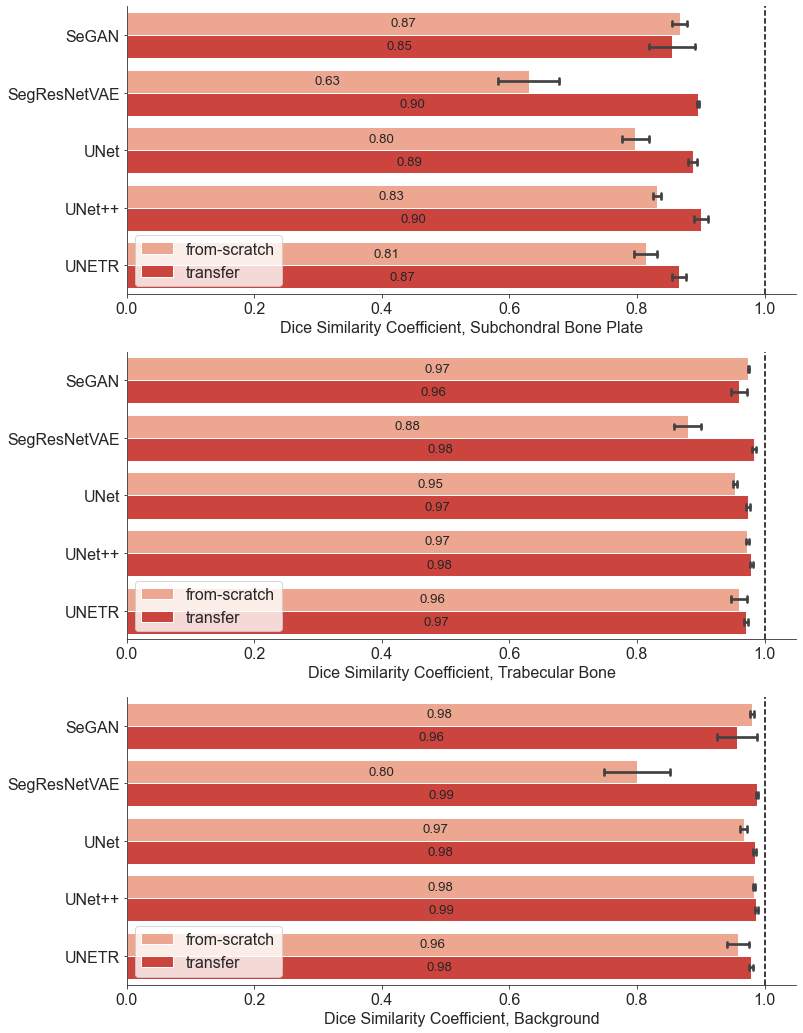

In [81]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Arial',
      'font.size' : 16}
plt.rcParams.update(rc)

metrics = {
    "cort DSC": "Dice Similarity Coefficient, Subchondral Bone Plate", 
    "trab DSC": "Dice Similarity Coefficient, Trabecular Bone", 
    "back DSC": "Dice Similarity Coefficient, Background"
}

fig, axs = plt.subplots(3,1,figsize=(12,18))

for metric, ax in zip(metrics, axs):

    ax.axvline(1, linestyle="--", c="k")
    ax = sns.barplot(
        ax=ax, data=df, y="label", x=metric, hue="training", palette="Reds", 
        ci="sd", capsize=0.1
    )
    #ax.legend_.remove()
    ax.legend(loc="lower left")
    
    ax.set(
        ylabel="",
        xlabel=metrics[metric]
    )

    for i in ax.containers:
        ax.bar_label(i, fmt="%0.2f", padding=0, label_type="center", fontsize="small")

    ax.grid(axis="x")
    sns.despine()

#ax.legend(loc="lower left")

plt.show()

There seems to be a tie in performance between the `SegResNetVAE` and the `UNet++`, each trained by transfer learning. We can transfer these models from ARC and show some visual examples (but not in this notebook, because I can't load checkpoints in jupyter notebooks for some reason).

Let's verify that for both of these models, we trained them for a sufficient period of time and they could not be made more accurate with longer training (more epochs and/or hours):

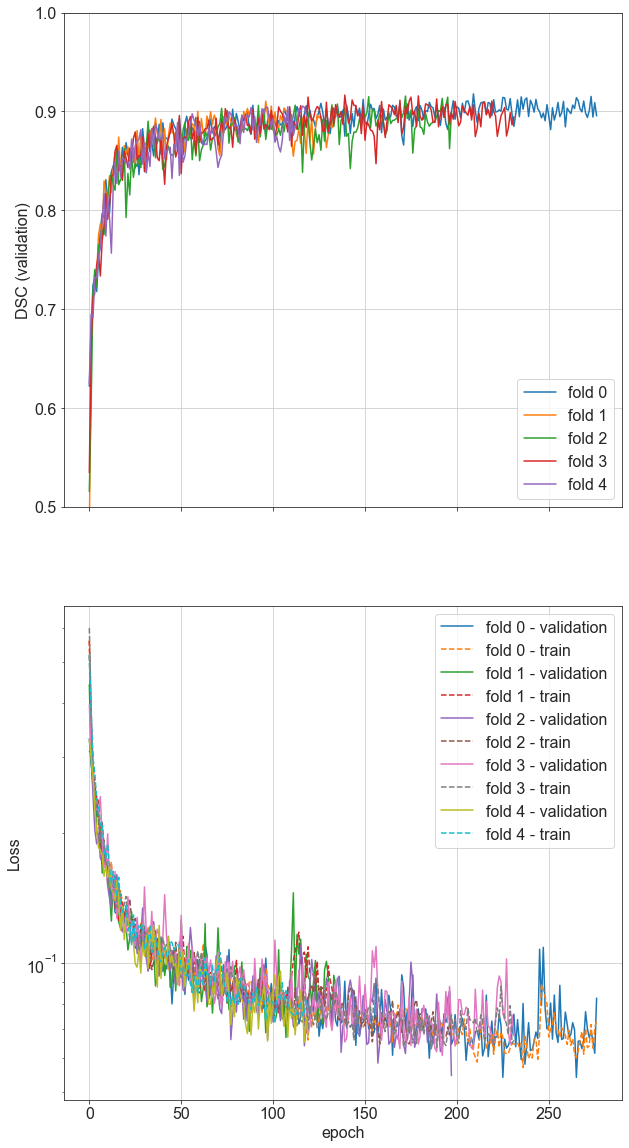

In [6]:
segresnetvae_metrics_fns = glob(
    path.join("..", "from_arc", "segresnetvae_3d_knee_transfer_cv", "*_f?", "metrics.csv")
)
segresnetvae_metrics_dfs = [pd.read_csv(fn) for fn in segresnetvae_metrics_fns]

sns.set_style("ticks",{'axes.grid' : True})

fig, axs = plt.subplots(2, 1, figsize=(10,20), sharex=True)


for i, srnv_df in enumerate(segresnetvae_metrics_dfs):
    sns.lineplot(ax=axs[0], data=srnv_df, x="epoch", y="val_dsc_0_epoch", label=f"fold {i}")
    sns.lineplot(ax=axs[1], data=srnv_df, x="epoch", y="val_loss_epoch", linestyle="-", label=f"fold {i} - validation")
    sns.lineplot(ax=axs[1], data=srnv_df, x="epoch", y="train_loss_epoch", linestyle="--", label=f"fold {i} - train")

axs[0].set_ylim(0.5,1)
axs[0].set_ylabel("DSC (validation)")

axs[1].set_yscale("log")
axs[1].set_ylabel("Loss")
    
plt.show()

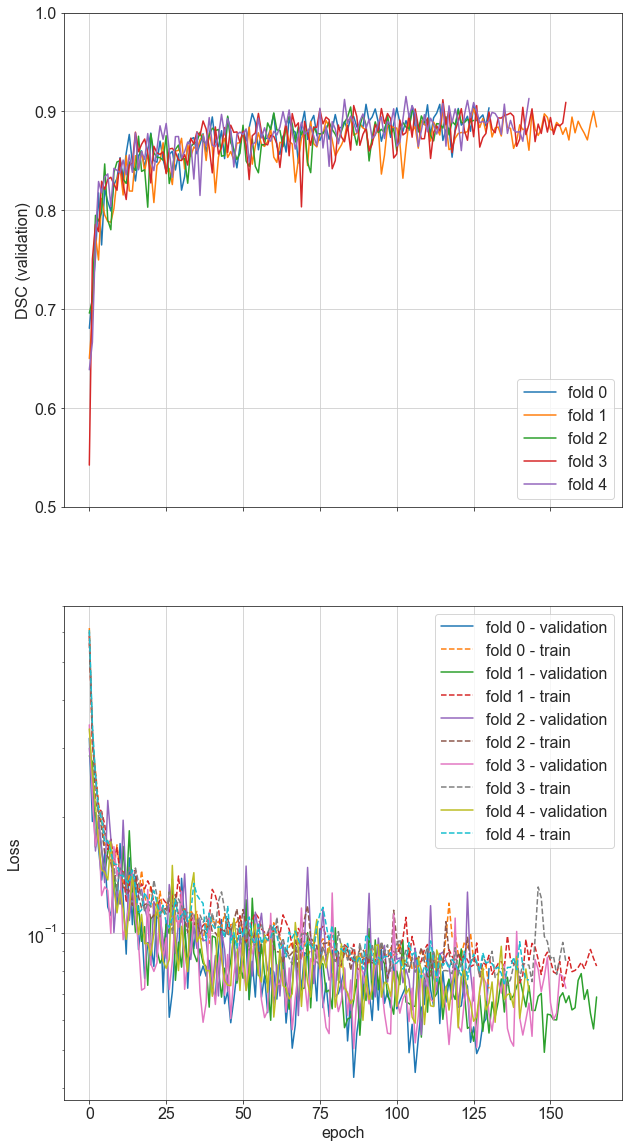

In [7]:
unetpp_metrics_fns = glob(
    path.join("..", "from_arc", "unetpp_3d_knee_transfer_cv", "*_f?", "metrics.csv")
)
unetpp_metrics_dfs = [pd.read_csv(fn) for fn in unetpp_metrics_fns]

sns.set_style("ticks",{'axes.grid' : True})

fig, axs = plt.subplots(2, 1, figsize=(10,20), sharex=True)


for i, upp_df in enumerate(unetpp_metrics_dfs):
    sns.lineplot(ax=axs[0], data=upp_df, x="epoch", y="val_dsc_0_epoch", label=f"fold {i}")
    sns.lineplot(ax=axs[1], data=upp_df, x="epoch", y="val_loss_epoch", linestyle="-", label=f"fold {i} - validation")
    sns.lineplot(ax=axs[1], data=upp_df, x="epoch", y="train_loss_epoch", linestyle="--", label=f"fold {i} - train")

axs[0].set_ylim(0.5,1)
axs[0].set_ylabel("DSC (validation)")

axs[1].set_yscale("log")
axs[1].set_ylabel("Loss")
    
plt.show()